 # 시계열 전처리 및 기본 모델링


# 1.환경준비

## (1) 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 데이터 불러오기

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path, usecols = ['date', 'sales'])
data = data.loc[data['date']<= '2014-10-31'].reset_index(drop = True)
data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].dt.day_name().str.slice(0,3)
data.head()

,date,sales,weekday
0,2013-01-01,45,Tue
1,2013-01-02,53,Wed
2,2013-01-03,65,Thu
3,2013-01-04,66,Fri
4,2013-01-05,97,Sat


* 변수 설명

    * date : 날짜
    * sales : 판매량
    * weekday : 요일

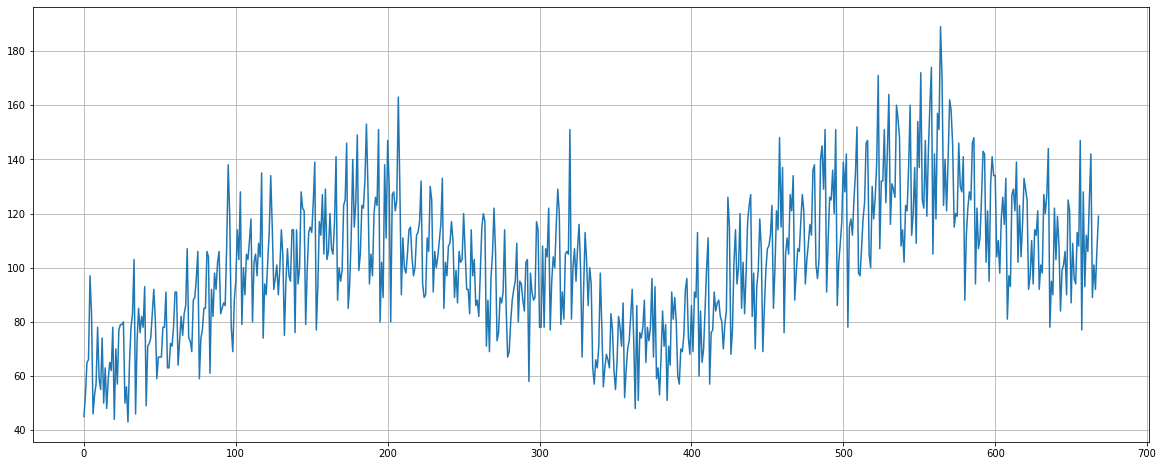

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

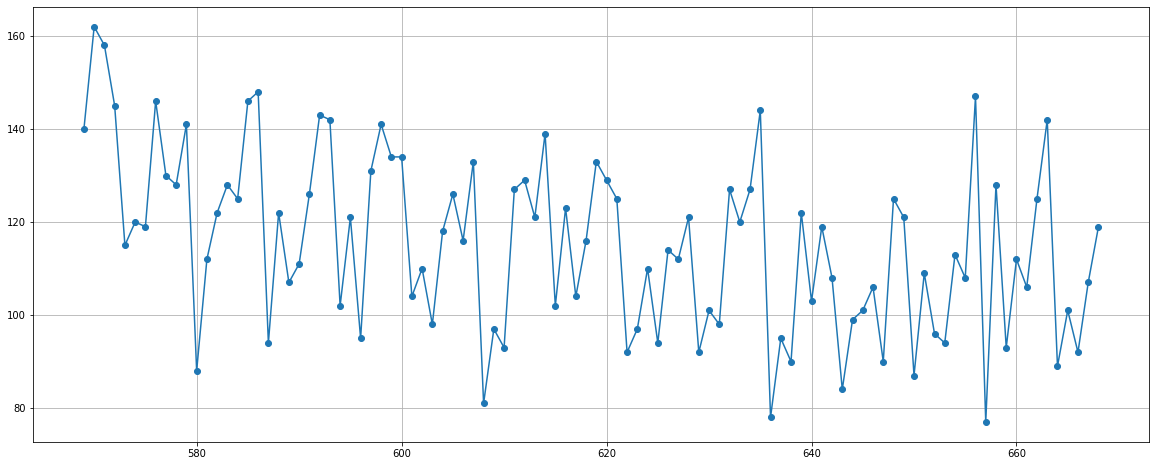

In [6]:
temp = data[-100:]
plt.figure(figsize = (20,8))
plt.plot(temp['sales'], marker ='o')
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

* 사전 관찰(look-ahead) : 미래의 어떤 사실을 안다는 뜻
* 사전 관찰 문제 : 
    * 데이터를 통해 실제로 알아야 하는 시점보다 더 일찍 미래에 대한 사실을 알게 되는 문제.  
    * 사전관찰 문제가 있는 채로 모델링을 하게 되면, 놀라운 성능의 모델이 만들어짐. --> 그러나 실제로는 불가능한 상황.

* 그래서 y를 만들때 사전관찰문제가 발생되지 않도록 해야 함.
    * 예제는 1일 후의 수요량을 예측하려고 합니다.

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [7]:
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,sales,weekday,y
0,2013-01-01,45,Tue,53.0
1,2013-01-02,53,Wed,65.0
2,2013-01-03,65,Thu,66.0
3,2013-01-04,66,Fri,97.0
4,2013-01-05,97,Sat,83.0


,date,sales,weekday,y
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0
668,2014-10-31,119,Fri,NaN


In [8]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,sales,weekday,y
663,2014-10-26,142,Sun,89.0
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0


## (2) 가변수화

In [9]:
data = pd.get_dummies(data, columns = ['weekday'], drop_first=False)

## (3) 데이터 분할

### 1) x, y 나누기

In [10]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False) 
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기
* k-fold cross validation for Time Seires : TimeSeriesSplit

In [11]:
# 여기서는 1회 분할로 진행합니다.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

# 3.시계열모델링① : ML 기반 모델링

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import * 

## (1) 모델링

In [15]:
m1 = LinearRegression()
m1.fit(x_train, y_train)

LinearRegression()

## (2) 검증

In [16]:
p1 = m1.predict(x_val)

print('RMSE : ', mean_squared_error(y_val, p1, squared = False))
print('MAE  : ', mean_absolute_error(y_val, p1))
print('MAPE : ', mean_absolute_percentage_error(y_val, p1))

RMSE :  16.250732000710066
MAE  :  13.42121742935482
MAPE :  0.12531131106824542


## (3) 결과 시각화

* pred를 시리즈로 바꾸고, 인덱스 맞추기

In [18]:
p1 = pd.Series(p1, index = y_val.index)
p1.head()

638     97.777191
639    124.168672
640    110.697560
641    123.954614
642     70.729089
dtype: float64

* y_train, y_val(전체), pred 한꺼번에 시각화 

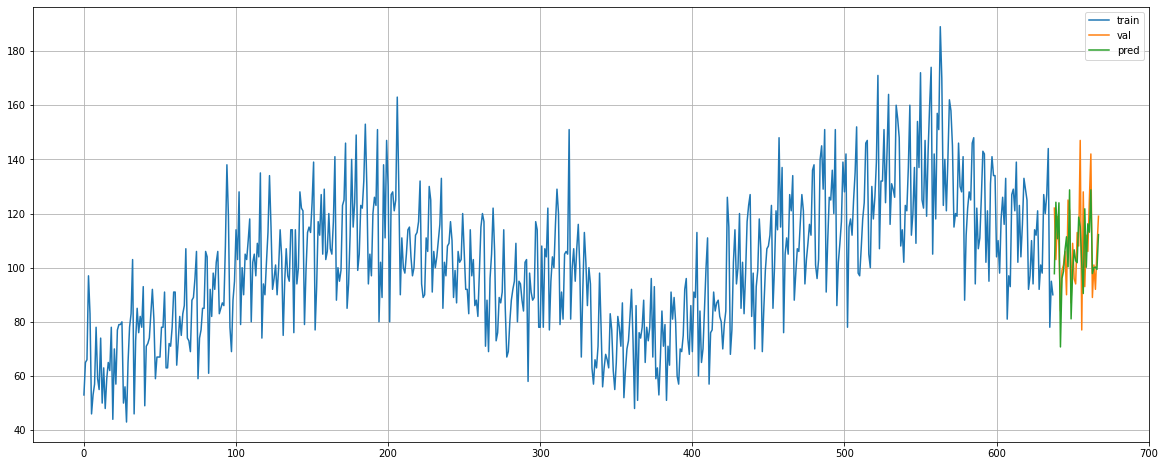

In [19]:
plt.figure(figsize = (20,8))
plt.plot(y_train, label = 'train')
plt.plot(y_val, label = 'val')
plt.plot(p1, label = 'pred')

plt.legend()
plt.grid()
plt.show()

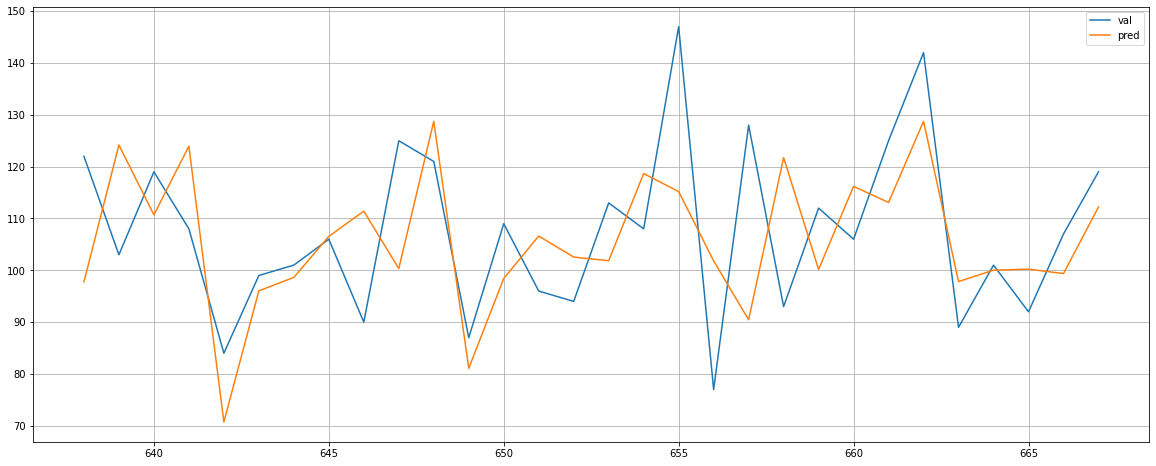

In [20]:
plt.figure(figsize = (20,8))
plt.plot(y_val, label = 'val')
plt.plot(p1, label = 'pred')

plt.legend()
plt.grid()
plt.show()

# 4.시계열모델링② : 전통적 시계열 모델링

## (1) 모델링

In [22]:
m2 = sm.tsa.SARIMAX(y_train, order=(4,1,4)).fit()
# sm: statsmodel.api
# tsa: time series analysis

## (2) 검증

In [23]:
p2 = m2.forecast(30) # train 이후 30일 데이터 예측

print('RMSE : ', mean_squared_error(y_val, p2, squared = False))
print('MAE  : ', mean_absolute_error(y_val, p2))
print('MAPE : ', mean_absolute_percentage_error(y_val, p2))

RMSE :  15.17848512755383
MAE  :  11.650603180164243
MAPE :  0.11100775090508731


## (3) 결과 시각화

* pred를 시리즈로 바꾸고, 인덱스 맞추기

In [24]:
p2 = pd.Series(p2, index = y_val.index)

* y_train, y_val(전체), pred 한꺼번에 시각화 

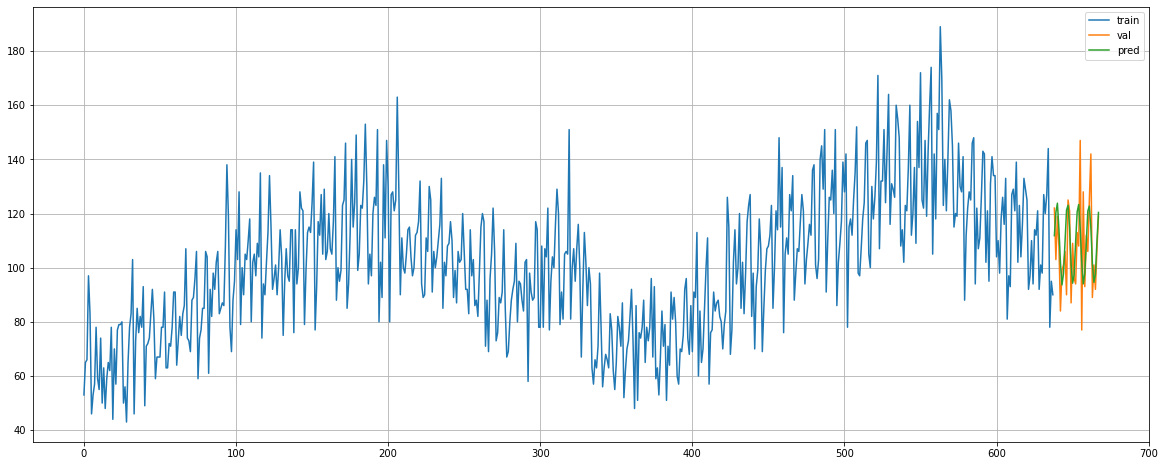

In [25]:
plt.figure(figsize = (20,8))
plt.plot(y_train, label = 'train')
plt.plot(y_val, label = 'val')
plt.plot(p2, label = 'pred')

plt.legend()
plt.grid()
plt.show()

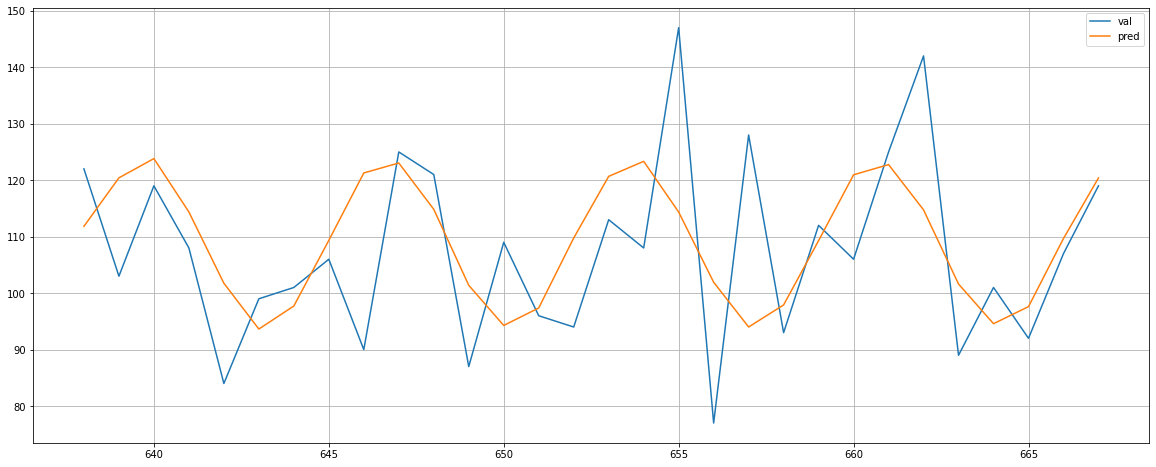

In [26]:
plt.figure(figsize = (20,8))
plt.plot(y_val, label = 'val')
plt.plot(p2, label = 'pred')

plt.legend()
plt.grid()
plt.show()

# 5.평가 : 잔차분석

* 잔차에 대한 우리의 기대 : 화이트 노이즈
    * 자기상관성 없음 : ACF, PACF 그래프
    * 정규분포 : Shapiro-Wilk 검정
    * 평균과 분산이 일정(Stationary) : ADF 검정
* 만약 화이트 노이즈가 아니라면...
    * 더 찾아내야 할 패턴이 있다는 의미.

## (1) ACF, PACF

* 정상 데이터 및 자기상관관계가 없는 데이터라면
* ACF, PACF 그래프에서
    * 첫번째 lag 에서부터 하늘색 범위 안에 값이 위치해야 하고
    * 값의 등락에 대한 어떠한 패턴도 보이지 않아야 합니다.
* 그러나 실제 데이터에서는 그런 결과를 보기 쉽지 않습니다.

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
residuals = m2.resid # train set의 오차들

### 1) ACF(자기 상관함수) 

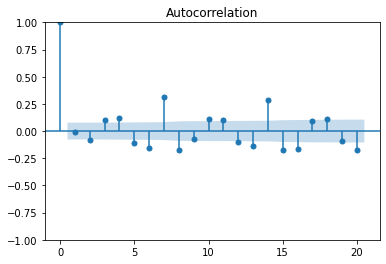

In [29]:
plot_acf(residuals, lags = 20)
plt.show()

In [30]:
res_df = pd.DataFrame({'residuals':residuals})

for i in range(1,21) :
    var = 'lag' + str(i)
    res_df[var] = res_df['residuals'].shift(i)

In [31]:
res_df.head(20)

,residuals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20
0,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12.011866,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.458530,12.011866,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34.286499,7.458530,12.011866,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.273136,34.286499,7.458530,12.011866,53.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-30.062033,10.273136,34.286499,7.458530,12.011866,53.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-11.285513,-30.062033,10.273136,34.286499,7.458530,12.011866,53.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.250528,-11.285513,-30.062033,10.273136,34.286499,7.458530,12.011866,53.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13.496519,-0.250528,-11.285513,-30.062033,10.273136,34.286499,7.458530,12.011866,53.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-14.735743,13.496519,-0.250528,-11.285513,-30.062033,10.273136,34.286499,7.458530,12.011866,53.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
res_df.corr()

,residuals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20
residuals,1.000000,-0.007985,-0.079460,0.101382,0.120750,-0.108291,-0.162724,0.324840,-0.178730,-0.076483,...,0.101605,-0.106358,-0.139970,0.293962,-0.185328,-0.170590,0.097796,0.118875,-0.090633,-0.177051
lag1,-0.007985,1.000000,-0.008814,-0.081757,0.103704,0.120875,-0.108286,-0.161525,0.325211,-0.178325,...,0.113831,0.100581,-0.107673,-0.141931,0.294683,-0.186085,-0.172505,0.097699,0.118562,-0.090605
lag2,-0.079460,-0.008814,1.000000,-0.011112,-0.079787,0.103840,0.120980,-0.106842,-0.161344,0.325973,...,-0.076852,0.112714,0.099412,-0.109750,-0.141415,0.294195,-0.188216,-0.172739,0.097345,0.118689
lag3,0.101382,-0.081757,-0.011112,1.000000,-0.005592,-0.079795,0.104263,0.125675,-0.106501,-0.160445,...,-0.178723,-0.080312,0.109892,0.095297,-0.108569,-0.143631,0.291182,-0.189150,-0.174286,0.097808
lag4,0.120750,0.103704,-0.079787,-0.005592,1.000000,-0.005826,-0.080145,0.100592,0.125389,-0.108206,...,0.325025,-0.176243,-0.077388,0.114936,0.094081,-0.107168,-0.139970,0.292398,-0.188703,-0.174962
lag5,-0.108291,0.120875,0.103840,-0.079795,-0.005826,1.000000,-0.005831,-0.080444,0.100568,0.125347,...,-0.159109,0.325445,-0.176263,-0.077325,0.114893,0.094180,-0.107158,-0.139957,0.292468,-0.188712
lag6,-0.162724,-0.108286,0.120980,0.104263,-0.080145,-0.005831,1.000000,-0.005947,-0.080464,0.100548,...,-0.108194,-0.159159,0.325827,-0.176456,-0.077382,0.114970,0.094440,-0.107150,-0.139944,0.292464
lag7,0.324840,-0.161525,-0.106842,0.125675,0.100592,-0.080444,-0.005947,1.000000,-0.006436,-0.081626,...,0.124880,-0.106116,-0.157153,0.330301,-0.177894,-0.076228,0.118546,0.094870,-0.106579,-0.140298
lag8,-0.178730,0.325211,-0.161344,-0.106501,0.125389,0.100568,-0.080464,-0.006436,1.000000,-0.006601,...,0.102037,0.125376,-0.105822,-0.156891,0.330199,-0.177739,-0.075833,0.118597,0.095002,-0.106605
lag9,-0.076483,-0.178325,0.325973,-0.160445,-0.108206,0.125347,0.100548,-0.081626,-0.006601,1.000000,...,-0.081708,0.102925,0.126325,-0.104886,-0.157330,0.330782,-0.176978,-0.075754,0.118882,0.094976


### 2) PACF

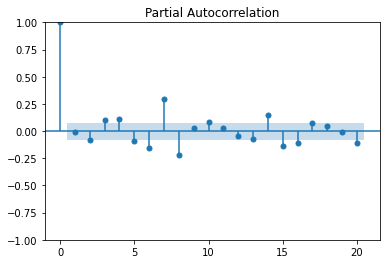

In [33]:
plot_pacf(residuals, lags = 20)
plt.show()

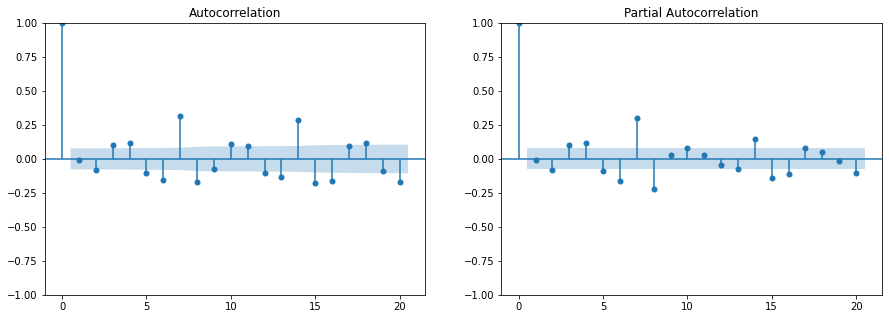

In [34]:
lags = 20

fig,ax = plt.subplots(1,2, figsize = (15,5))
plot_acf(residuals, lags = lags, ax = ax[0])
plot_pacf(residuals, lags = lags, ax = ax[1])
plt.show()

## (2) 검정
검정 도구를 적용하여 의사결정하는 용도로만 사용합니다.

In [35]:
import scipy.stats as spst
import statsmodels.api as sm

### 1) 정규성 검정 : Shapiro-Wilk 검정

* 귀무가설 : **정규 분포이다.** (p-value > 0.05)
* 대립가설 : 정규분포가 아니다.

In [36]:
spst.shapiro(residuals)[1]

0.006060344632714987

### 2) 정상성 검정 : ADF 검정

* 귀무가설 : 비정상(Non-Stationary) 데이터이다.
* 대립가설 : **정상(Stationary) 데이터**이다.(P-value <= 0.05)

In [37]:
# ADF 테스트
sm.tsa.stattools.adfuller(residuals)[1]

3.302254779518776e-05

# 6.함수로 만들기

## (1) 결과 시각화

In [38]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

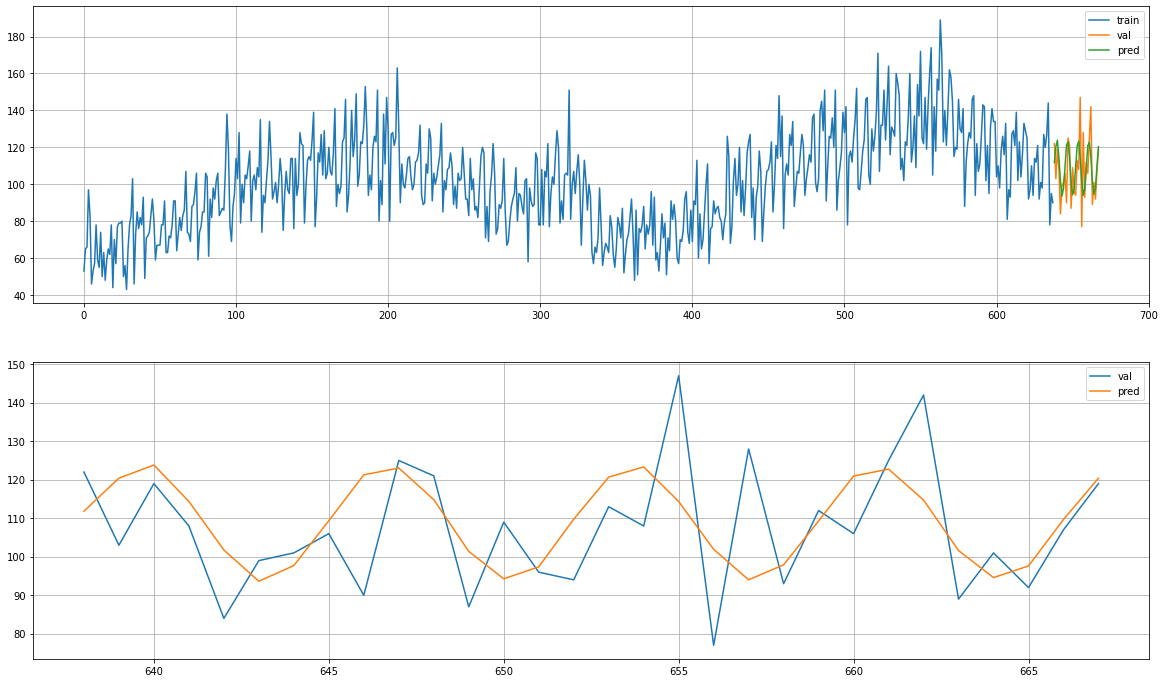

In [39]:
plot_model_result(y_train, y_val, p2)

## (2) 잔차분석

In [40]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

* 정규성 검정(> 0.05) :  0.00606
* 정상성 검정(< 0.05) :  3e-05
* 자기상관성 확인(ACF, PACF)


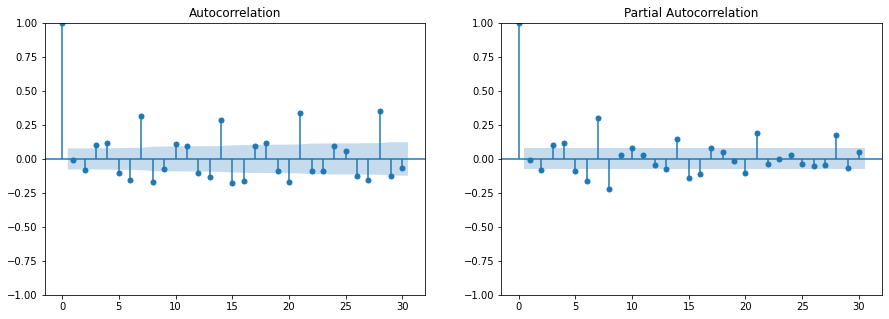

In [41]:
residual_diag(residuals, lags = 30)